## Network Analysis
We defined correlation between businesses based on user-rated 'stars'. The star ranking takes values ranging between 1 - 5. When the star-ranking is positively correlated between two businesses, they are connected with a red edge in the business network. When the star-ranking is negatively correlated between two businesses, they are connected with a blue edge. We used Spearman's ranked correlation analysis. We included the following businesses:
- Restaurants in Phoenix
- Restaurants in Las Vegas

In [1]:
from load_yelp_data import load_yelp_dataframe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline
import networkx as nx
import random
import scipy.stats

In [2]:
#Load data
businesses = load_yelp_dataframe('businesses').drop('Unnamed: 0', 1)
reviews = load_yelp_dataframe('reviews').drop('Unnamed: 0', 1)
users = load_yelp_dataframe('users').drop('Unnamed: 0', 1)

In [3]:
businesses.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,"{'Accepts Credit Cards': True, 'Noise Level': ...",0,"['Fast Food', 'Restaurants']",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{'Monday': {'close': '21:00', 'open': '11:00'}...",40.354327,-79.900706,Mr Hoagie,[],True,7,3.5,PA,business
1,"{'Accepts Credit Cards': True, 'Price Range': ...",1,['Nightlife'],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350553,-79.886814,Clancy's Pub,[],True,5,3.0,PA,business
2,{'Good for Kids': True},2,"['Active Life', 'Mini Golf', 'Golf']",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.354116,-80.014660,Cool Springs Golf Center,[],False,5,2.5,PA,business
3,"{'Accepts Credit Cards': True, 'Noise Level': ...",3,"['Bars', 'American (New)', 'Nightlife', 'Loung...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{'Tuesday': {'close': '19:00', 'open': '10:00'...",40.408830,-79.866211,Emil's Lounge,[],True,26,4.5,PA,business
4,"{'Accepts Credit Cards': True, 'Takes Reservat...",4,"['Active Life', 'Golf']",Braddock,"1000 Clubhouse Dr\nBraddock, PA 15104","{'Friday': {'close': '20:00', 'open': '11:00'}...",40.403405,-79.855782,Grand View Golf Club,[],True,3,5.0,PA,business


In [4]:
#Classify the datapoints into the cities based on the latitude and the longitude
cities = np.array([['Edinburgh', 55.9533, -3.1883, 0, 0],
         ['Karlsruhe', 49.0069, 8.4037, 0, 0],
         ['Montreal', 45.5017, -73.5673, 0, 0],
         ['Waterloo', 43.4643, -80.5204, 0, 0],
         ['Pittsburgh', 40.4406, -79.9959, 0, 0],
         ['Charlotte', 35.2271, -80.8431, 0, 0],
         ['Urbana-Champaign', 40.1106, -88.2073, 0, -150000],
         ['Phoenix', 33.4484, -112.0740, 0, 0],
         ['Las Vegas', 36.1699, -115.1398, 0, 0],
         ['Madison', 43.0731, -89.4012, 0, 0]])
lat = np.array(cities[:,1], np.float32)
lon = np.array(cities[:,2], np.float32)
x_offsets = np.array(cities[:,3], np.float32)
y_offsets = np.array(cities[:,4], np.float32)

def classify_datapoint_by_latitude_and_longitude(datapoint):
#     print datapoint
    latitude = datapoint['latitude']
    longitude = datapoint['longitude']
    distances = (latitude - lat)**2 + (longitude - lon)**2
    min_dist = np.argmin(distances)
    return cities[min_dist, 0]

businesses['location'] = businesses.apply(classify_datapoint_by_latitude_and_longitude, axis=1)

In [5]:
##Due to the memory error, first select cities and restaurants
#Choose Las Vegas and Phoenix only
businesses_2cities = businesses[ (businesses['location'] == 'Phoenix') | (businesses['location'] == 'Las Vegas') ]

#Select restaurants
is_restaurants = []
for i in range(0, businesses_2cities.shape[0]):
    if "Restaurants" in businesses_2cities.iloc[i, 2]:
        is_restaurants.append(True)
    else:
        is_restaurants.append(False)

restaurants = businesses_2cities[is_restaurants]

In [6]:
##Clean and merge businesses data with reviews data
#Rename duplicated column names between businesses and reviews datasets
restaurants = restaurants.rename(columns = {'stars': 'stars_business'})

#Merge with the reviews dataset
restaurants_reviews = reviews.merge(restaurants, how='inner', on='business_id') 

#When users reviewed a business more than once, take the most updated review result
restaurants_reviews = restaurants_reviews.sort_values(by=['year', 'month', 'day'], ascending=True, axis=0)
restaurants_reviews_nodup = restaurants_reviews.drop_duplicates(subset=('user_id', 'business_id'), keep='last')

## Las Vegas and Phoenix
We constructed a network in train set. X axis indicates longitude, and Y axis is latitude in the network graph.

In [42]:
##Create Las Vegas and Phoenix data##
#Due to memory error, top 100 restraurants were chosen to do predictions
LVrestaurants = restaurants_reviews_nodup[ restaurants_reviews_nodup['location'] == 'Las Vegas' ]
PHrestaurants = restaurants_reviews_nodup[ restaurants_reviews_nodup['location'] == 'Phoenix' ]

#Create train and test sets
#Output: correlation matrix and top100 business_ids in each column for train and test sets
def train_and_test(df):
    #Slect top 100 frequently rated restaurants
    df100count = df['business_id'].value_counts()[:100]
    df100id = df100count.index
    mask = df['business_id'].isin(df100id)
    df100 = df[mask]

    n, m = df100.shape
    train = df100.sample(n=int(0.7*n), replace=False, random_state=1000)
    test = df100.drop(train.index)
    
    #Drop unnecessary variables
    train2 = train[['user_id', 'business_id', 'stars']]
    test2 = test[['user_id', 'business_id', 'stars']]
    
    #Create correlation matrix of star rating for train and test sets
    train_t = train2.pivot(index='user_id', columns='business_id', values='stars')
    train_corr_matrix = train_t.corr(method='spearman')
    #train_corr_matrix_values = train_corr_matrix.reset_index().values

    test_t = test2.pivot(index='user_id', columns='business_id', values='stars')
    test_corr_matrix = test_t.corr(method='spearman')
    #test_corr_matrix_values = test_corr_matrix.reset_index().values
    
    return train_corr_matrix, train, test_corr_matrix, test

LV_train, LV_train100, LV_test, LV_test100 = train_and_test(LVrestaurants)
PH_train, PH_train100, PH_test, PH_test100 = train_and_test(PHrestaurants)

## Training set for Las Vegas

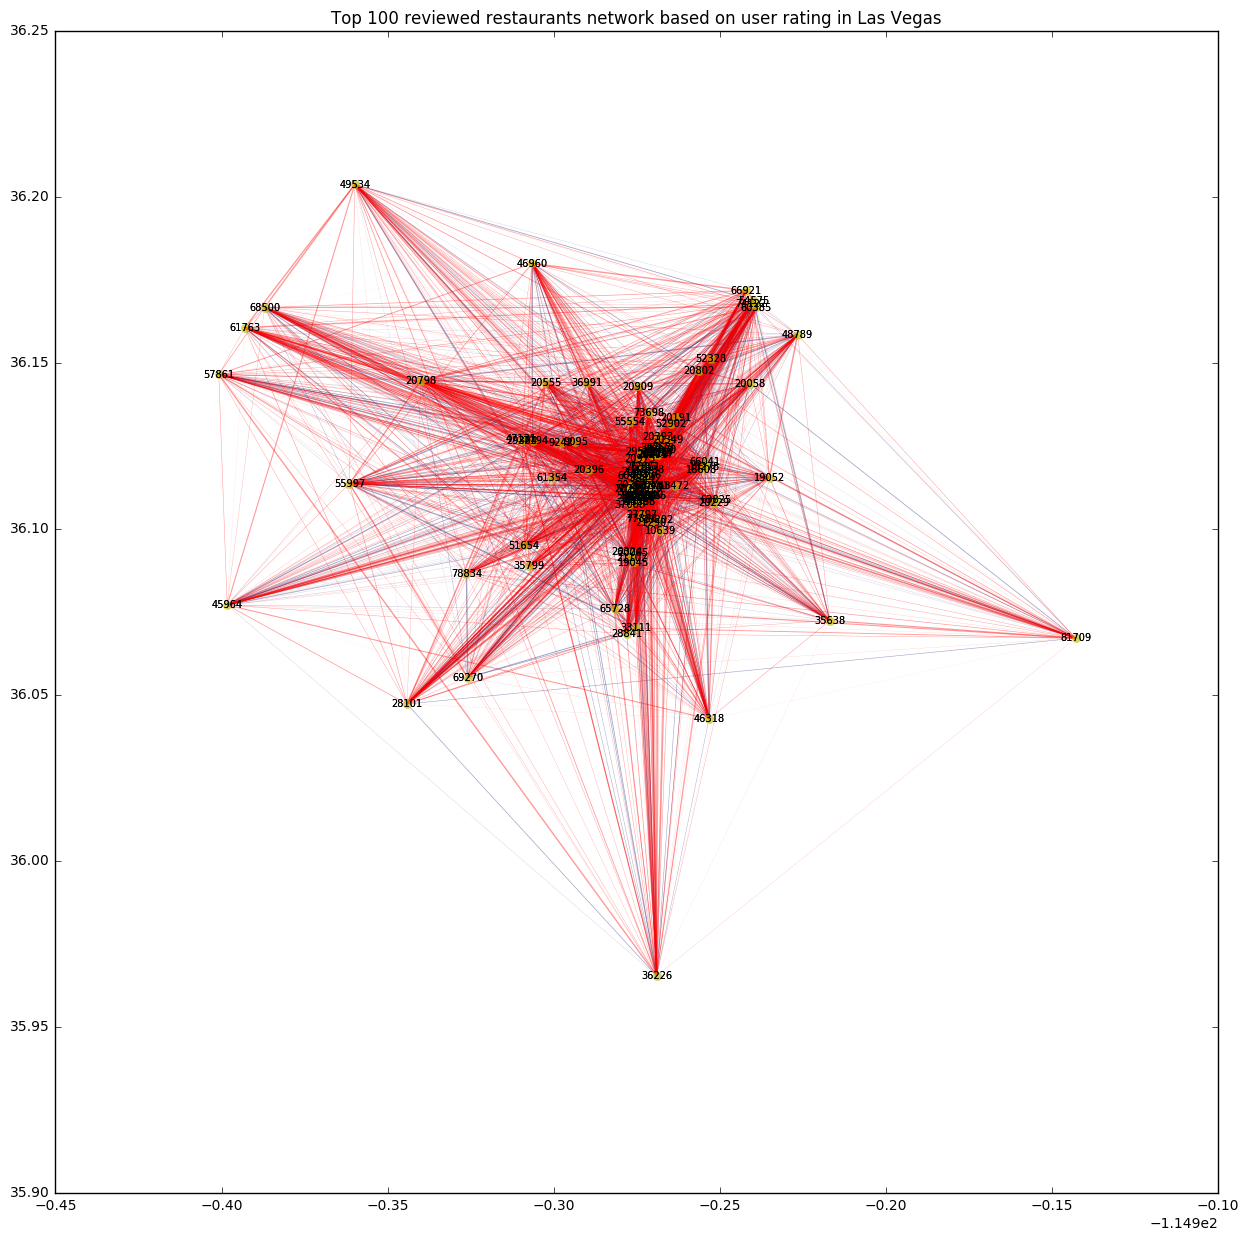

In [48]:
##Construct Las Vegas network using top 100 reviewed restaurants in the train set
#Create position for the network
posx = []
for i in range(0, LV_train100.shape[0]):
    posx.append((LV_train100.iloc[i, 1], [LV_train100.iloc[i, 12], LV_train100.iloc[i, 11]]))#business id, longitude, latitude

position_dic = dict(posx)

node0=[]
node1=[]
weight0=[]
weight1=[]
columns=LV_train.columns.values
LVcorr_matrix_values = LV_train.reset_index().values
for i, line in enumerate(LVcorr_matrix_values):
    tokens=LVcorr_matrix_values[i]
    row=tokens[0]
    for column, cell in zip(columns[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            node0.append(( int(row), int(column) ))
            weight0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            node1.append(( int(row), int(column) ))
            weight1.append(float(cell))

#remove self-edge
node1 = [x for x in node1 if x[0] != x[1]]
            
G0=nx.Graph()
G0.add_nodes_from(columns)
G0.add_edges_from(node0)
G1=nx.Graph()
G1.add_nodes_from(columns)
G1.add_edges_from(node1)

weight0x=[i for i in weight0]
weight1x=[i*(-1) for i in weight1]

plt.figure(figsize=(15, 15))
plt.title('Top 100 reviewed restaurants network based on user rating in Las Vegas')
nx.draw_networkx(G0, position_dic, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(G1, position_dic, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Number of nodes: 100
Number of total edges: 4638
Median degree: 95.0


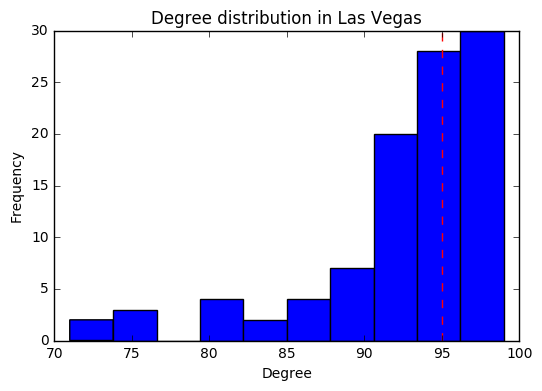

In [134]:
##Network characteristics
# Negative and positive network combined
G01=nx.Graph()
G01.add_nodes_from(columns)
node=[]
node=list(node0 + node1)
weight=list(weight0 + weight1)
G01.add_edges_from(node)

#Number of nodes
print 'Number of nodes:', len(G01.nodes())

#Number of edges
print 'Number of total edges:', len(G01.edges()) 

#Median degree
median_degree_LV = np.median(G01.degree().values())
print 'Median degree:', median_degree_LV

#Degree distribution
plt.title('Degree distribution in Las Vegas')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G01.degree().values())
plt.axvline(median_degree_LV, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [146]:
##Rank all businesses using PageRank and weight

pr = nx.pagerank(G01, weight='weight') #pr is dictionary. All values sum up to 1
#sum(pr.values()) returns 1

#Convert percentage to 1-5 values based on the star distribution percentile (5 star is above 43 percentile)
for x, y in pr.items():
    if pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[:1] / LV_train100.shape[0])*100 ): 
        pr[x] = 5 
    elif pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[1:2] / LV_train100.shape[0])*100 ): 
        pr[x] = 4
    elif pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[2:3] / LV_train100.shape[0])*100 ): 
        pr[x] = 3
    elif pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[3:4] / LV_train100.shape[0])*100 ): 
        pr[x] = 2
    else:
        pr[x] = 1


## Testing set for Las Vegas

In [147]:
pred_LV = []
for i in LV_test100['business_id']:
    pred_LV.append(pr[i])

stars_LV = LV_test100['stars']

N = LV_test100.shape[0]
RSS = np.sum( (pred_LV - stars_LV)**2 )
RSE = np.sqrt( RSS / (N-2))

print RSE

2.0


This analysis included 100 businesses located in Las Vegas. The node in the network figure indicates a business ID, and an edge represents a connection between businesses. The correlation coefficients were calcuated using Spearman's ranked correlation analysis. The red color indicates positive correlation, and the blue color is negative correlation between businesses. Using PageRank algorithm of this network model (https://en.wikipedia.org/wiki/PageRank), we predicted the importance of businesses in the test set and assigned stars based on the star distribution (i.e., porportional to the observed star counts in the train set). This results shows that the RSE was 2.0, indicating that this model would not perform well compared with the other models we tested.